In [7]:
import sys
import pandas as pd
sys.path.append("..")
import seaborn as sns
import nltk

from humor.metric import fuzzy_match_metric
from humor.bipartite_metric import bipartite_metric

In [8]:
import pandas as pd
from thefuzz import fuzz

def bipartite_metric(model_answers: pd.DataFrame, ground_truth: pd.DataFrame):  
    # Find the similarity of the model answers and ground truth by using fuzzy string matching
    score_matrix = model_answers.apply(
        lambda row_model: ground_truth.apply(
            lambda row_truth: 
                fuzz.ratio(row_truth["sentence"], row_model["sentence"]) 
                if row_model["comedian"] == row_truth["comedian"] 
                else None,
        axis=1),
    axis=1) \
        .melt(ignore_index=False) \
        .dropna() \
        .reset_index()
    # Find the best score by taking the maximum value
    best_match = score_matrix.loc[score_matrix.groupby("index")["value"].idxmax()].reset_index(drop=True)
    
    #Add in the ground truths that were not matched
    missing_gt = set(ground_truth.index) - set(best_match["variable"].unique())
    missing_gt = pd.DataFrame({"index": None, "variable": list(missing_gt), "value": 0})
    
    result = best_match.append(missing_gt).groupby("variable").mean().rename(columns={"value": "score"})
    
    # Add in the comedians and group by the mean for each comedian
    final_result = result.merge(ground_truth[['comedian']], left_index=True, right_index=True).reset_index(drop=True)
    
    return final_result.groupby('comedian')['score'].mean().reset_index()
    
    # ground_truth["value"] = 0
    # ground_truth.loc[~ground_truth.index.isin(best_match["variable"]), "value"]
    
    # scores = model_answers.apply(
    #     lambda row_model: ground_truth.apply(
    #         lambda row_truth: 
    #             fuzz.ratio(row_truth["sentence"], row_model["sentence"]) 
    #             if row_model["comedian"] == row_truth["comedian"] 
    #             else None,
    #     axis=1),
    # axis=1) \
    #     .melt(ignore_index=False) \
    #     .dropna() \
    #     .reset_index() \
    #     .join(model_answers["sentence"], on="index") \
    #     .rename(columns={"sentence": "model"}) \
    #     .join(ground_truth, on="variable") \
    #     .rename(columns={"sentence": "truth", "value": "score"})
        
    # scores = scores[["comedian", "model", "truth", "score"]]
    # print("scores", scores)
    
    # df = scores.groupby(["comedian", "model"])[["score", "truth"]].max().reset_index()
    # print("df")
    # print(df)
    # truths = scores[~scores['truth'].isin(df['truth'])]
    # print("truths")
    # print(truths)
    
    # entries = truths.copy()
    # entries['score'] = 0
    # print("entries")
    # print(entries)
    # df = pd.concat([df, entries[['comedian', 'model', 'truth', 'score']]], ignore_index=True)
    # df.sort_values(by=['comedian', 'model'], inplace=True)
    # print("df")
    # print(df)
    
    # return df.groupby("truth")["score"].mean().reset_index()

In [9]:
ground_truth = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_data.csv')
model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/gemma_answers.csv')
transcript = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_transcripts.csv')

In [10]:
#ground truth x ground truth
gt = bipartite_metric(ground_truth, ground_truth)
gt.mean()

/tmp/ipykernel_830578/4253546501.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gt.mean()


score    100.0
dtype: float64

In [11]:
wrong = pd.DataFrame().reindex_like(ground_truth).drop(["laugh_start", "laugh_end"], axis=1)
wrong["comedian"] = ground_truth["comedian"]
wrong["sentence"] = ""
completely_wrong = bipartite_metric(wrong, ground_truth)
completely_wrong.mean()

/tmp/ipykernel_830578/3677872773.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  completely_wrong.mean()


score    0.0
dtype: float64

In [12]:
#gemma
gemma_metric = bipartite_metric(model, ground_truth)

In [13]:
gemma_metric

,comedian,score
0,Ali_Wong,30.900000
1,Ali_Wong_2,29.250000
2,Anthony_Jeselnik,34.142857
3,Anthony_Jeselnik_2,63.000000
4,Chelsea_Peretti,24.400000
5,Chelsea_Peretti_2,18.000000
6,Donald_Glover,21.000000
7,Donald_Glover_2,14.666667
8,Hasan_Minhaj,32.300000
9,Hasan_Minhaj_2,44.833333


In [14]:
gemma_metric.max()

comedian    Trevor_Noah_2
score                63.0
dtype: object

In [15]:
model[model["comedian"] == "Trevor_Noah_2"]

,comedian,sentence
111,Trevor_Noah_2,You can't be normal man with a voice like that...
112,Trevor_Noah_2,It just doesn't work. I remember when Nelson M...
113,Trevor_Noah_2,"Everything he did, he'd just be like, 'Ah, kno..."


In [16]:
ground_truth[ground_truth["comedian"] == "Trevor_Noah_2"]

,comedian,laugh_start,laugh_end,sentence
231,Trevor_Noah_2,13.273,17.662,You can't do normal things with that voice. Yo...
232,Trevor_Noah_2,26.474,27.698,"""Who the hell is this?!"" ""I'm not telling you."""
233,Trevor_Noah_2,38.852,40.535,[laughs] It just doesn't work. I remember when...
234,Trevor_Noah_2,49.724,51.042,He still kept what was him. It was partly beca...
235,Trevor_Noah_2,60.423,62.326,"People would be like, ""Let him in. Let him in!"""
236,Trevor_Noah_2,74.216,78.397,Who's here? Who are we?'


In [17]:
gemma_metric.min()

comedian    Ali_Wong
score       7.058824
dtype: object

In [18]:
model[model["comedian"] == "Ali_Wong"]

,comedian,sentence
6,Ali_Wong,It was like the worst experience of my life. I...
7,Ali_Wong,Those of you under 25 probably don't know what...
8,Ali_Wong,It was like the Tesla of my time.
9,Ali_Wong,I'm not trying to be a procrastinator anymore....


In [19]:
ground_truth[ground_truth["comedian"] == "Ali_Wong"]

,comedian,laugh_start,laugh_end,sentence
71,Ali_Wong,21.007,28.986,It was like the worst experience of my life. I...
72,Ali_Wong,33.005,37.756,We were screaming and fighting and yelling and...
73,Ali_Wong,48.803,51.189,We were all required to buy it when we were in...
74,Ali_Wong,58.001,69.002,All because what? It could graph.
75,Ali_Wong,95.523,98.684,I do know... that I'm gonna have to clean all ...


In [20]:
gemma_metric["score"].mean() 

28.661891796688508

In [21]:
#Brute Force
brute_sentences = []
for i in range(len(transcript['comedian'])):
    comedian = transcript['comedian'][i]
    trans = transcript['transcript'][i]
    sentences = nltk.sent_tokenize(trans)
    for sentence in sentences:
        brute_sentences.append({'comedian': comedian, 'sentence': sentence})

In [22]:
brute_model = pd.DataFrame(brute_sentences)

In [23]:
brute = bipartite_metric(brute_model, ground_truth)

In [24]:
brute

,comedian,score
0,Ali_Wong,56.150000
1,Ali_Wong_2,63.906250
2,Anthony_Jeselnik,55.976190
3,Anthony_Jeselnik_2,51.166667
4,Chelsea_Peretti,42.533333
5,Chelsea_Peretti_2,58.777778
6,Donald_Glover,55.178571
7,Donald_Glover_2,62.092593
8,Hasan_Minhaj,48.346667
9,Hasan_Minhaj_2,45.833333


In [25]:
brute["score"].mean() 

56.160050449838515

In [26]:
#random
random_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/random_gemma_quotes.csv")
random = bipartite_metric(random_model, ground_truth)
random["score"].mean() 

27.524339749222968

In [27]:
random

,comedian,score
0,Ali_Wong,46.933333
1,Ali_Wong_2,48.625000
2,Anthony_Jeselnik,26.071429
3,Anthony_Jeselnik_2,34.666667
4,Chelsea_Peretti,19.333333
5,Chelsea_Peretti_2,26.666667
6,Donald_Glover,6.571429
7,Donald_Glover_2,17.037037
8,Hasan_Minhaj,11.200000
9,Hasan_Minhaj_2,43.555556


In [28]:
gemma = gemma_metric.assign(model="gemma") 
brute = brute.assign(model="brute") 
random = random.assign(model="random") 

In [29]:
df = pd.concat([gemma, brute, random]).reset_index(drop=True)

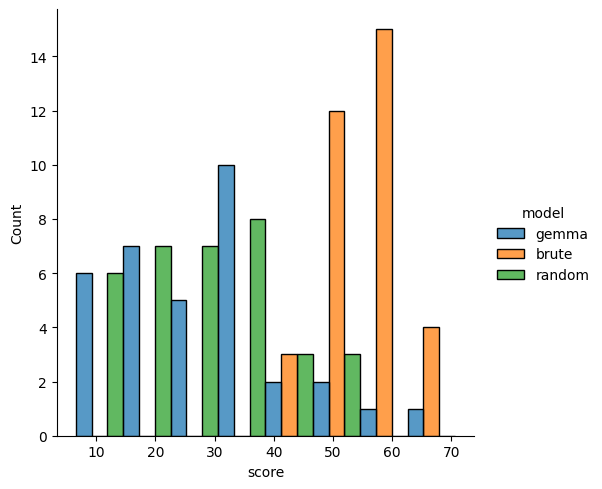

In [30]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

In [31]:
phi_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/phi3_mini_quotes.csv")
phi_metric = bipartite_metric(phi_model, ground_truth)
phi_metric["score"].mean() 

24.892822868212143

In [32]:
phi = phi_metric.assign(model="phi") 

In [33]:
llm = pd.concat([gemma, phi, brute, random]).reset_index(drop=True)

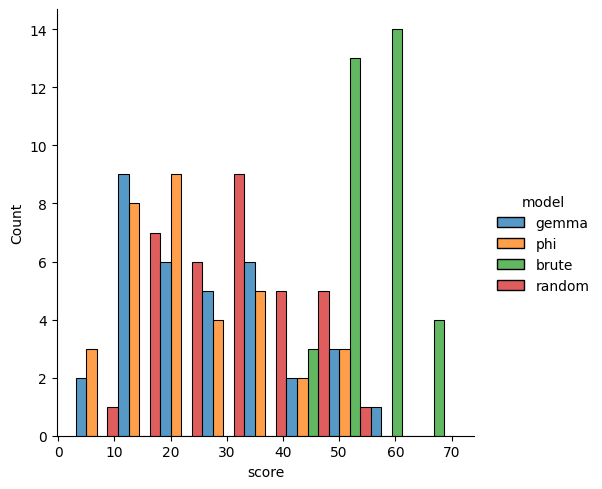

In [34]:
sns.displot(llm, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

Chat_GPT

In [35]:
chatgpt_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/Chat_GPT_results - Sheet1.csv")
chatgpt_model
# chatgpt_model = bipartite_metric(chatgpt_model, ground_truth)
# phi_metric["score"].mean() * 100

,comedian,sentence
0,Jimmy_Yang,"Asian people, we don’t need Tinder anymore. We..."
1,Jimmy_Yang,"I’ve been dating a lot of tall girls lately, b..."
2,Jimmy_Yang,"She’s like, it makes my ass look better. I’m l..."
3,Jimmy_Yang,Last time– the last time I took a tall girl to...
4,Jimmy_Yang,I’m 5′ 5″. I just go to concerts to smell othe...
5,Jimmy_Yang,"She was having the time of her life, doing wha..."
6,Jimmy_Yang,I was frustrated. I had enough. So I just look...
7,Russell_Peters,"He goes, look, you’re a 48-year-old Indian man..."
8,Russell_Peters,There is no way you can be Indian and not have...
9,Russell_Peters,There’s no way you can consume the food that w...


In [36]:
chatgpt_jm = chatgpt_model[chatgpt_model["comedian"] == "John_Mulaney"]
ground_truth_jm = ground_truth[ground_truth["comedian"]== "John_Mulaney"]
# chatgpt_model = bipartite_metric(chatgpt_model, ground_truth)
# phi_metric["score"].mean() * 100

In [37]:
ground_truth_jm

,comedian,laugh_start,laugh_end,sentence
49,John_Mulaney,20.2350,22.6280,My wife and I just gave a bunch of stuff to Go...
50,John_Mulaney,30.5460,32.0200,"And then one day my wife said, ""Hey, you took ..."
51,John_Mulaney,44.3320,46.4850,"I was like, ""This one's shirts. I got a bunch ..."
52,John_Mulaney,59.4920,65.8650,"He's like, ""Take this receipt for the clothing..."
53,John_Mulaney,67.8500,70.7620,My mom said it could be a sleep shirt. Please ...
54,John_Mulaney,73.5270,74.2070,That sleep shirt bullshit.
55,John_Mulaney,83.9075,85.8990,"""Well, if it's too big you can just wear it as..."
56,John_Mulaney,97.7550,105.9800,"""Because we don't say that when someone gives ..."
57,John_Mulaney,113.7820,125.0765,So rather than violate these meaningless polit...


In [38]:
chatgpt_metric_jm = bipartite_metric(chatgpt_jm, ground_truth_jm)
print(chatgpt_metric_jm)

       comedian      score
0  John_Mulaney  39.055556


In [39]:
chatgpt_metric_jm["score"].mean() 

39.05555555555556

In [40]:
model_jm = model[model["comedian"] == "John_Mulaney"]
model_jm = bipartite_metric(model_jm, ground_truth_jm)
model_jm["score"].mean() 

31.944444444444443

## Different Prompts

##### "The following is a stand-up comedy transcript. When performed in front of a live audience, which jokes do you think made the audience laugh?  List of quotes:"

In [41]:
laugh = pd.read_csv('/home/ada/humor/data/stand_up_dataset/prompts/laugh_prompt - Sheet1.csv')

In [42]:
laugh_metric = bipartite_metric(laugh, ground_truth)
laugh_metric

,comedian,score
0,Ali_Wong,26.600000
1,Ali_Wong_2,34.500000
2,Anthony_Jeselnik,22.714286
3,Anthony_Jeselnik_2,58.333333
4,Chelsea_Peretti,24.400000
5,Chelsea_Peretti_2,27.500000
6,Donald_Glover,12.142857
7,Donald_Glover_2,14.444444
8,Hasan_Minhaj,26.100000
9,Hasan_Minhaj_2,25.500000


In [43]:
laugh_metric.mean()

/tmp/ipykernel_830578/3345081846.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  laugh_metric.mean()


score    27.511146
dtype: float64

#### The following is a stand-up comedy transcript. What are the funniest punchlines from the transcript. List of quotes:"

In [44]:
punchline = pd.read_csv('/home/ada/humor/data/stand_up_dataset/prompts/punchline_prompt - Sheet1.csv')

In [45]:
punchline_metric = bipartite_metric(punchline, ground_truth)
punchline_metric

,comedian,score
0,Ali_Wong,28.100000
1,Ali_Wong_2,17.937500
2,Anthony_Jeselnik,24.000000
3,Anthony_Jeselnik_2,34.666667
4,Chelsea_Peretti,24.400000
5,Chelsea_Peretti_2,14.888889
6,Donald_Glover,11.857143
7,Donald_Glover_2,14.333333
8,Hasan_Minhaj,39.100000
9,Hasan_Minhaj_2,58.333333


In [46]:
punchline_metric.mean()

/tmp/ipykernel_830578/3771637599.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  punchline_metric.mean()


score    27.833417
dtype: float64

#### Below is a transcript from a stand-up comedy routine. Analyze the transcript and extract the quotes that are most likely to have made the audience laugh. List of quotes:

In [47]:
most_laugh = pd.read_csv('/home/ada/humor/data/stand_up_dataset/prompts/mostlaugh_prompt - Sheet1.csv')

In [48]:
most_laugh_metric = bipartite_metric(most_laugh, ground_truth)
most_laugh_metric

,comedian,score
0,Ali_Wong,37.933333
1,Ali_Wong_2,28.875000
2,Anthony_Jeselnik,22.500000
3,Anthony_Jeselnik_2,26.833333
4,Chelsea_Peretti,24.400000
5,Chelsea_Peretti_2,14.888889
6,Donald_Glover,11.857143
7,Donald_Glover_2,22.777778
8,Hasan_Minhaj,25.600000
9,Hasan_Minhaj_2,46.833333


In [49]:
most_laugh_metric.mean()

/tmp/ipykernel_830578/3010234896.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  most_laugh_metric.mean()


score    26.074917
dtype: float64

In [50]:
laugh = laugh_metric.assign(model="laugh") 
punchline = punchline_metric.assign(model="punchline")
most_laugh = most_laugh_metric.assign(model="most_laugh")

In [51]:
df = pd.concat([gemma, laugh, punchline, most_laugh]).reset_index(drop=True)

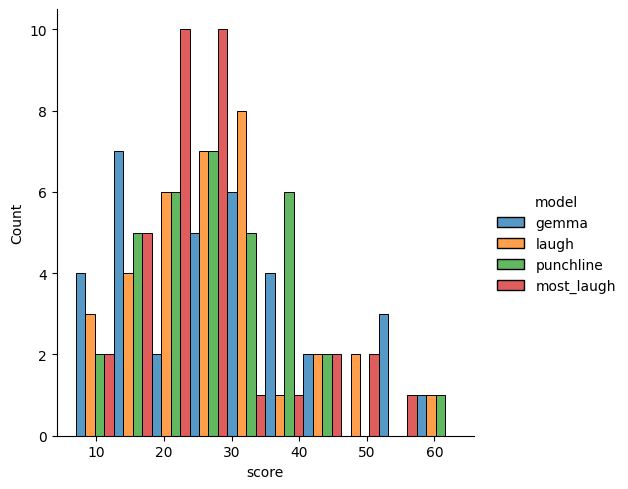

In [52]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

In [53]:
llm_gt = ground_truth.loc[ground_truth["comedian"].isin(["John_Mulaney", "Jimmy_Yang", "Russell_Peters", "Ali_Wong", "Hasan_Minhaj"])]

In [54]:
llm_gt

,comedian,laugh_start,laugh_end,sentence
49,John_Mulaney,20.2350,22.6280,My wife and I just gave a bunch of stuff to Go...
50,John_Mulaney,30.5460,32.0200,"And then one day my wife said, ""Hey, you took ..."
51,John_Mulaney,44.3320,46.4850,"I was like, ""This one's shirts. I got a bunch ..."
52,John_Mulaney,59.4920,65.8650,"He's like, ""Take this receipt for the clothing..."
53,John_Mulaney,67.8500,70.7620,My mom said it could be a sleep shirt. Please ...
54,John_Mulaney,73.5270,74.2070,That sleep shirt bullshit.
55,John_Mulaney,83.9075,85.8990,"""Well, if it's too big you can just wear it as..."
56,John_Mulaney,97.7550,105.9800,"""Because we don't say that when someone gives ..."
57,John_Mulaney,113.7820,125.0765,So rather than violate these meaningless polit...
71,Ali_Wong,21.0070,28.9860,It was like the worst experience of my life. I...


In [55]:
chatgpt = pd.read_csv("/home/ada/humor/data/stand_up_dataset/Chat_GPT_results - Sheet1.csv")

In [56]:
chatgpt

,comedian,sentence
0,Jimmy_Yang,"Asian people, we don’t need Tinder anymore. We..."
1,Jimmy_Yang,"I’ve been dating a lot of tall girls lately, b..."
2,Jimmy_Yang,"She’s like, it makes my ass look better. I’m l..."
3,Jimmy_Yang,Last time– the last time I took a tall girl to...
4,Jimmy_Yang,I’m 5′ 5″. I just go to concerts to smell othe...
5,Jimmy_Yang,"She was having the time of her life, doing wha..."
6,Jimmy_Yang,I was frustrated. I had enough. So I just look...
7,Russell_Peters,"He goes, look, you’re a 48-year-old Indian man..."
8,Russell_Peters,There is no way you can be Indian and not have...
9,Russell_Peters,There’s no way you can consume the food that w...


In [57]:
chatgpt_metric = bipartite_metric(chatgpt, llm_gt)
chatgpt_metric

,comedian,score
0,Ali_Wong,41.100000
1,Hasan_Minhaj,34.400000
2,Jimmy_Yang,26.958333
3,John_Mulaney,39.055556
4,Russell_Peters,42.000000


In [58]:
chatgpt_metric.mean()

/tmp/ipykernel_830578/1572520876.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  chatgpt_metric.mean()


score    36.702778
dtype: float64

In [59]:
claude = pd.read_csv("/home/ada/humor/data/stand_up_dataset/Claude_results - Sheet1.csv")

In [60]:
claude_metric = bipartite_metric(claude, llm_gt)
claude_metric

,comedian,score
0,Ali_Wong,46.633333
1,Hasan_Minhaj,46.066667
2,Jimmy_Yang,28.500000
3,John_Mulaney,33.222222
4,Russell_Peters,34.250000


In [61]:
claude_metric.mean()

/tmp/ipykernel_830578/2380763216.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  claude_metric.mean()


score    37.734444
dtype: float64

In [62]:
gemma_llm = model.loc[model["comedian"].isin(["John_Mulaney", "Jimmy_Yang", "Russell_Peters", "Ali_Wong", "Hasan_Minhaj"])]

In [63]:
gemma_llm_metric = bipartite_metric(gemma_llm, llm_gt)
gemma_llm_metric.mean()

/tmp/ipykernel_830578/1130048052.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gemma_llm_metric.mean()


score    30.728889
dtype: float64

In [64]:
gemma = gemma_llm_metric.assign(model = "gemma")
claude = claude_metric.assign(model="claude") 
chatgpt = chatgpt_metric.assign(model="chatgpt")

In [65]:
df = pd.concat([gemma, claude, chatgpt]).reset_index(drop=True)

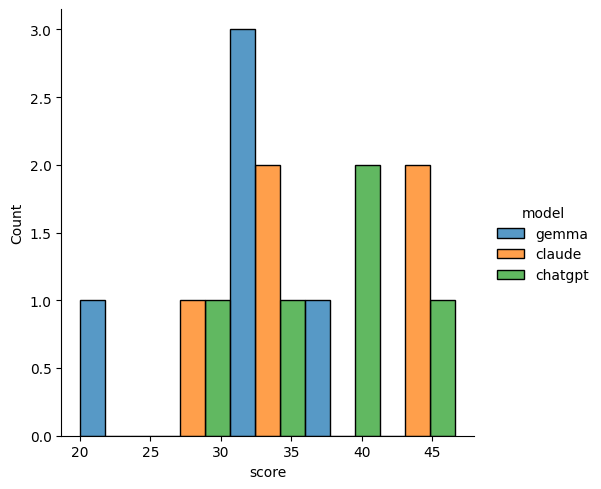

In [66]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

## More tokens

In [67]:
gemma200 = pd.read_csv("/home/ada/humor/data/stand_up_dataset/gemma200tokens - Sheet1.csv")

In [68]:
gemma200_metric = bipartite_metric(gemma200, ground_truth)
gemma200_metric

,comedian,score
0,Ali_Wong,35.300000
1,Ali_Wong_2,29.125000
2,Anthony_Jeselnik,42.214286
3,Anthony_Jeselnik_2,62.666667
4,Chelsea_Peretti,24.400000
5,Chelsea_Peretti_2,18.000000
6,Donald_Glover,34.000000
7,Donald_Glover_2,19.833333
8,Hasan_Minhaj,32.300000
9,Hasan_Minhaj_2,32.666667


In [69]:
gemma200_metric.mean()

/tmp/ipykernel_830578/568904367.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gemma200_metric.mean()


score    30.905338
dtype: float64

In [70]:
gemma_metric = bipartite_metric(model, ground_truth)
gemma_metric.mean()

/tmp/ipykernel_830578/1305976714.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gemma_metric.mean()


score    28.661892
dtype: float64

In [71]:
gemma = gemma_metric.assign(model = "gemma")
gemma200 = gemma200_metric.assign(model="gemma200") 


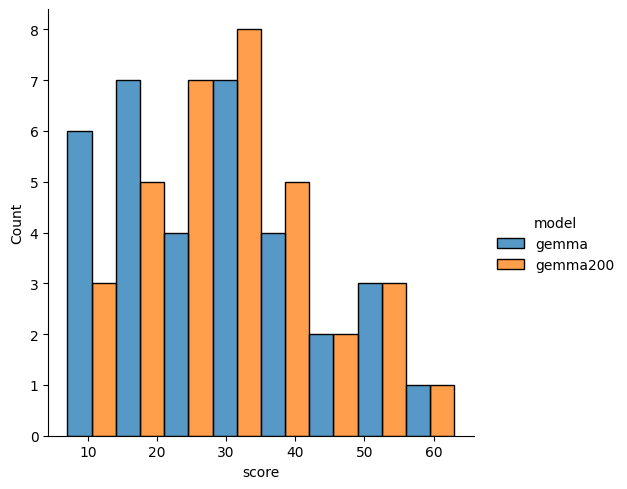

In [72]:
sns.displot(pd.concat([gemma, gemma200]).reset_index(drop=True), x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

# Play pretend

In [73]:
comedian_pretend = pd.read_csv("/home/ada/humor/data/stand_up_dataset/comedian_quotes - Sheet1.csv")
comedian_pretend_metric = bipartite_metric(comedian_pretend, ground_truth)
comedian_pretend_metric

,comedian,score
0,Ali_Wong,27.400000
1,Ali_Wong_2,34.125000
2,Anthony_Jeselnik,33.857143
3,Anthony_Jeselnik_2,34.666667
4,Chelsea_Peretti,24.400000
5,Chelsea_Peretti_2,18.000000
6,Donald_Glover,21.000000
7,Donald_Glover_2,15.888889
8,Hasan_Minhaj,37.400000
9,Hasan_Minhaj_2,34.166667


In [74]:
comedian_pretend_metric.mean()

/tmp/ipykernel_830578/1875112182.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  comedian_pretend_metric.mean()


score    25.353437
dtype: float64

In [75]:
comedyfan_pretend = pd.read_csv("/home/ada/humor/data/stand_up_dataset/comedy_fan_laughter_quotes - Sheet1.csv")
comedyfan_pretend_metric = bipartite_metric(comedyfan_pretend, ground_truth)
comedyfan_pretend_metric

,comedian,score
0,Ali_Wong,27.400000
1,Ali_Wong_2,31.750000
2,Anthony_Jeselnik,33.857143
3,Anthony_Jeselnik_2,63.333333
4,Chelsea_Peretti,24.400000
5,Chelsea_Peretti_2,18.000000
6,Donald_Glover,21.000000
7,Donald_Glover_2,15.888889
8,Hasan_Minhaj,48.200000
9,Hasan_Minhaj_2,34.166667


In [76]:
comedyfan_pretend_metric.mean()

/tmp/ipykernel_830578/3683433526.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  comedyfan_pretend_metric.mean()


score    27.426196
dtype: float64

In [77]:
comedycritic_pretend = pd.read_csv("/home/ada/humor/data/stand_up_dataset/comedy_critic_quotes - Sheet1.csv")
comedycritic_pretend_metric = bipartite_metric(comedycritic_pretend, ground_truth)
comedycritic_pretend_metric

,comedian,score
0,Ali_Wong,30.000000
1,Ali_Wong_2,21.625000
2,Anthony_Jeselnik,33.857143
3,Anthony_Jeselnik_2,63.333333
4,Chelsea_Peretti,24.400000
5,Chelsea_Peretti_2,18.000000
6,Donald_Glover,21.000000
7,Donald_Glover_2,15.888889
8,Hasan_Minhaj,14.200000
9,Hasan_Minhaj_2,34.166667


In [78]:
comedycritic_pretend_metric.mean()

/tmp/ipykernel_830578/2664976109.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  comedycritic_pretend_metric.mean()


score    25.643465
dtype: float64

In [79]:
gemma = gemma_llm_metric.assign(model = "gemma")
fan = comedyfan_pretend_metric.assign(model="fan") 
comedian = comedian_pretend_metric.assign(model="comedian") 
critic = comedycritic_pretend_metric.assign(model="critic")

In [80]:
df = pd.concat([gemma, fan, comedian, critic]).reset_index(drop=True)

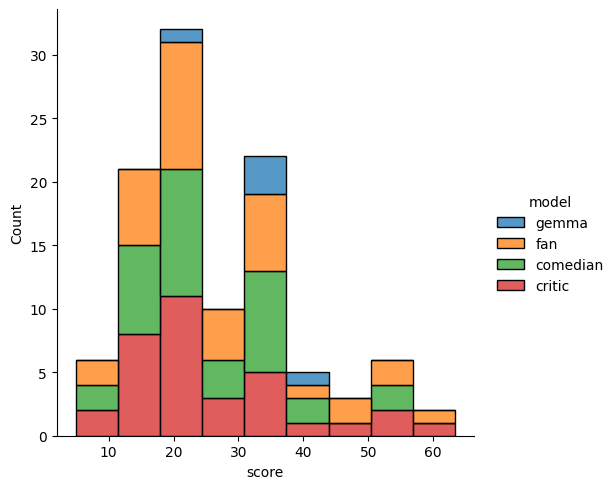

In [81]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="stack")

## Decoding

Top-K

In [82]:
top_k = pd.read_csv("/home/ada/humor/data/stand_up_dataset/k_sample - Sheet1.csv")

In [83]:
top_k_df = {}
for i in range(1, 11):
    top_k_df[f'df_k_{i}'] = top_k[top_k['k'] == i]


In [84]:
k_1 = top_k_df['df_k_1']
k_2 = top_k_df['df_k_2']
k_3 = top_k_df['df_k_3']
k_4 = top_k_df['df_k_4']
k_5 = top_k_df['df_k_5']
k_6 = top_k_df['df_k_6']
k_7 = top_k_df['df_k_7']
k_8 = top_k_df['df_k_8']
k_9 = top_k_df['df_k_9']
k_10 = top_k_df['df_k_10']

In [85]:
k1_metric = bipartite_metric(k_1, ground_truth)
k1_metric.mean()

/tmp/ipykernel_830578/2551170758.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k1_metric.mean()


score    28.132622
dtype: float64

In [86]:
k2_metric = bipartite_metric(k_2, ground_truth)
k2_metric.mean()

/tmp/ipykernel_830578/2657943919.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k2_metric.mean()


score    25.148267
dtype: float64

In [87]:
k3_metric = bipartite_metric(k_3, ground_truth)
k3_metric.mean()

/tmp/ipykernel_830578/1990443186.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k3_metric.mean()


score    25.99111
dtype: float64

In [88]:
k4_metric = bipartite_metric(k_4, ground_truth)
k4_metric.mean()

/tmp/ipykernel_830578/2657779777.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k4_metric.mean()


score    23.980281
dtype: float64

In [89]:
k5_metric = bipartite_metric(k_5, ground_truth)
k5_metric.mean()

/tmp/ipykernel_830578/1940522433.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k5_metric.mean()


score    26.265753
dtype: float64

In [90]:
k6_metric = bipartite_metric(k_6, ground_truth)
k6_metric.mean()

/tmp/ipykernel_830578/797404915.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k6_metric.mean()


score    26.453674
dtype: float64

In [91]:
k7_metric = bipartite_metric(k_7, ground_truth)
k7_metric.mean()

/tmp/ipykernel_830578/661257255.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k7_metric.mean()


score    23.340401
dtype: float64

In [92]:
k8_metric = bipartite_metric(k_8, ground_truth)
k8_metric.mean()

/tmp/ipykernel_830578/2862372342.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k8_metric.mean()


score    24.764554
dtype: float64

In [93]:
k9_metric = bipartite_metric(k_9, ground_truth)
k9_metric.mean()

/tmp/ipykernel_830578/1132242517.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k9_metric.mean()


score    25.511432
dtype: float64

In [94]:
k10_metric = bipartite_metric(k_10, ground_truth)
k10_metric.mean()

/tmp/ipykernel_830578/3968851987.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k10_metric.mean()


score    25.127992
dtype: float64

In [95]:
k1 = k1_metric.assign(model = "k=1")
k2 = k2_metric.assign(model = "k=2")
k3 = k3_metric.assign(model = "k=3")
k4 = k4_metric.assign(model = "k=4")
k5 = k5_metric.assign(model = "k=5")
k6 = k6_metric.assign(model = "k=6")
k7 = k7_metric.assign(model = "k=7")
k8 = k8_metric.assign(model = "k=8")
k9 = k9_metric.assign(model = "k=9")
k10 = k10_metric.assign(model = "k=10")

In [96]:
df = pd.concat([k1, k2, k3, k4, k5, k6, k7, k8, k9, k10]).reset_index(drop=True)

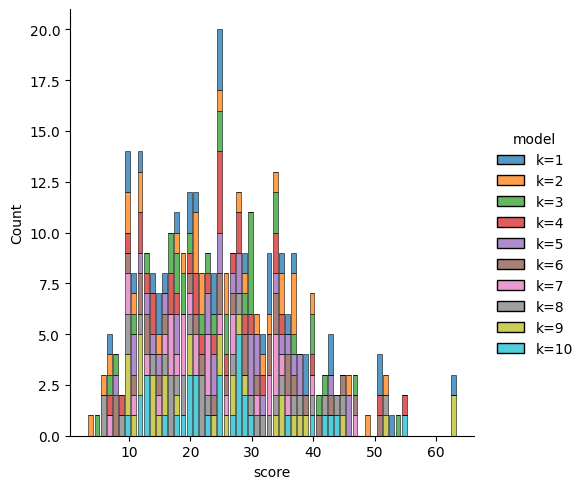

In [97]:
sns.displot(df, x="score", hue="model", kind="hist", multiple="stack", shrink=0.8, binwidth=1.0)

In [99]:
k1_metric

,comedian,score
0,Ali_Wong,43.200000
1,Ali_Wong_2,29.250000
2,Anthony_Jeselnik,23.857143
3,Anthony_Jeselnik_2,62.666667
4,Chelsea_Peretti,24.400000
5,Chelsea_Peretti_2,18.000000
6,Donald_Glover,21.000000
7,Donald_Glover_2,9.444444
8,Hasan_Minhaj,32.100000
9,Hasan_Minhaj_2,32.500000


<AxesSubplot:xlabel='variable', ylabel='value'>

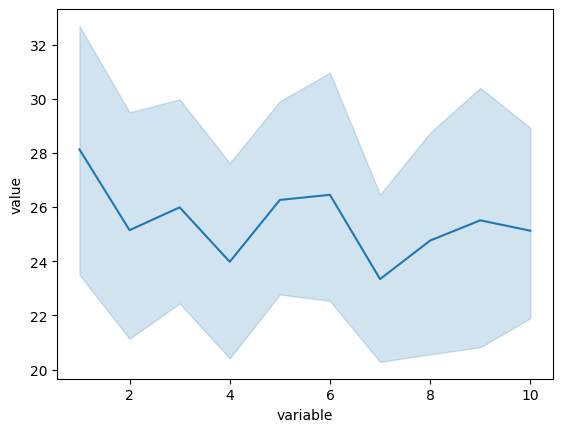

In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

k_vals = pd.DataFrame({
    1: k1_metric["score"],
    2: k2_metric["score"],
    3: k3_metric["score"],
    4: k4_metric["score"],
    5: k5_metric["score"],
    6: k6_metric["score"],
    7: k7_metric["score"],
    8: k8_metric["score"],
    9: k9_metric["score"],
    10: k10_metric["score"],
}).melt()

sns.lineplot(k_vals, x="variable", y="value")

# plt.figure(figsize=(10, 6))
# plt.plot(k_values, means, marker='o', linestyle='-', color='pink')

# plt.title('Mean Metrics for k Values from 1 to 10')
# plt.xlabel('k Value')
# plt.ylabel('Mean Metric')
# plt.xticks(k_values)
# plt.legend()
# plt.grid(True)
# plt.show()

## Top-p

In [ ]:
top_p = pd.read_csv("/home/ada/humor/data/stand_up_dataset/p_sample - Sheet1.csv")

In [ ]:
top_p

,comedian,sentence,p
0,Anthony_Jeselnik,"When I was a kid, I used to fantasize about ge...",0.00
1,Anthony_Jeselnik,My mom actually should’ve been on one of the p...,0.00
2,Anthony_Jeselnik,"When I was a kid, like nine years old, I’d com...",0.00
3,Anthony_Jeselnik,"When I was a kid, I used to fantasize about ge...",0.90
4,Anthony_Jeselnik,My mom actually should’ve been on one of the p...,0.90
...,...,...,...
1416,Tom_Segura_2,"There's ""Hold Open,"" and ""Close."" And you can ...",0.98
1417,Tom_Segura_2,I got such a warm rush through my body. It fel...,0.99
1418,Tom_Segura_2,"There’s “Hold Open,” and “Close.” And you can ...",0.99
1419,Tom_Segura_2,I got such a warm rush through my body. It fel...,1.00


In [ ]:
top_p_df = {}
for p in [0] + [i / 100 for i in range(90, 101)]:
    top_p_df[f'df_p_{p}'] = top_p[top_p['p'] == p]

In [ ]:
p_0 = top_p_df['df_p_0']
p_9 = top_p_df['df_p_0.9']
p_91 = top_p_df['df_p_0.91']
p_92 = top_p_df['df_p_0.92']
p_93 = top_p_df['df_p_0.93']
p_94 = top_p_df['df_p_0.94']
p_95 = top_p_df['df_p_0.95']
p_96 = top_p_df['df_p_0.96']
p_97 = top_p_df['df_p_0.97']
p_98 = top_p_df['df_p_0.98']
p_99 = top_p_df['df_p_0.99']
p_1 = top_p_df['df_p_1.0']

In [ ]:
p0_metric = bipartite_metric(p_0, ground_truth)
p0_metric.mean()

/tmp/ipykernel_760118/1682444344.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p0_metric.mean()


score    27.455016
dtype: float64

In [ ]:
p9_metric = bipartite_metric(p_9, ground_truth)
p9_metric.mean()

/tmp/ipykernel_760118/737289714.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p9_metric.mean()


score    24.071963
dtype: float64

In [ ]:
p91_metric = bipartite_metric(p_91, ground_truth)
p91_metric.mean()

/tmp/ipykernel_760118/1267983535.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p91_metric.mean()


score    24.977192
dtype: float64

In [ ]:
p92_metric = bipartite_metric(p_92, ground_truth)
p92_metric.mean()

/tmp/ipykernel_760118/3663633955.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p92_metric.mean()


score    25.238499
dtype: float64

In [ ]:
p93_metric = bipartite_metric(p_93, ground_truth)
p93_metric.mean()

/tmp/ipykernel_760118/3124393155.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p93_metric.mean()


score    25.729869
dtype: float64

In [ ]:
p94_metric = bipartite_metric(p_94, ground_truth)
p94_metric.mean()

/tmp/ipykernel_760118/1826973090.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p94_metric.mean()


score    24.392475
dtype: float64

In [ ]:
p95_metric = bipartite_metric(p_95, ground_truth)
p95_metric.mean()

/tmp/ipykernel_760118/2858370961.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p95_metric.mean()


score    27.138062
dtype: float64

In [ ]:
p96_metric = bipartite_metric(p_96, ground_truth)
p96_metric.mean()

/tmp/ipykernel_760118/3544092099.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p96_metric.mean()


score    24.256798
dtype: float64

In [ ]:
p97_metric = bipartite_metric(p_97, ground_truth)
p97_metric.mean()

/tmp/ipykernel_760118/1387252451.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p97_metric.mean()


score    23.148864
dtype: float64

In [ ]:
p98_metric = bipartite_metric(p_98, ground_truth)
p98_metric.mean()

/tmp/ipykernel_760118/63609148.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p98_metric.mean()


score    26.599481
dtype: float64

In [ ]:
p99_metric = bipartite_metric(p_99, ground_truth)
p99_metric.mean()

/tmp/ipykernel_760118/2626852736.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p99_metric.mean()


score    26.945566
dtype: float64

In [ ]:
p1_metric = bipartite_metric(p_1, ground_truth)
p1_metric.mean()

/tmp/ipykernel_760118/2209821856.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p1_metric.mean()


score    22.860475
dtype: float64

In [ ]:
p0 = p0_metric.assign(model = "p=0")
p9 = p9_metric.assign(model = "p=9")
p91 = p91_metric.assign(model = "p=91")
p92 = p92_metric.assign(model = "p=92")
p93 = p93_metric.assign(model = "p=93")
p94 = p94_metric.assign(model = "p=94")
p95 = p95_metric.assign(model = "p=95")
p96 = p96_metric.assign(model = "p=96")
p97 = p97_metric.assign(model = "p=97")
p98 = p98_metric.assign(model = "p=98")
p99 = p99_metric.assign(model = "p=99")
p1 = p1_metric.assign(model = "p=1")

In [ ]:
df = pd.concat([p0, p9, p91, p92, p93, p94, p95, p96, p97, p98, p99, p1]).reset_index(drop=True)

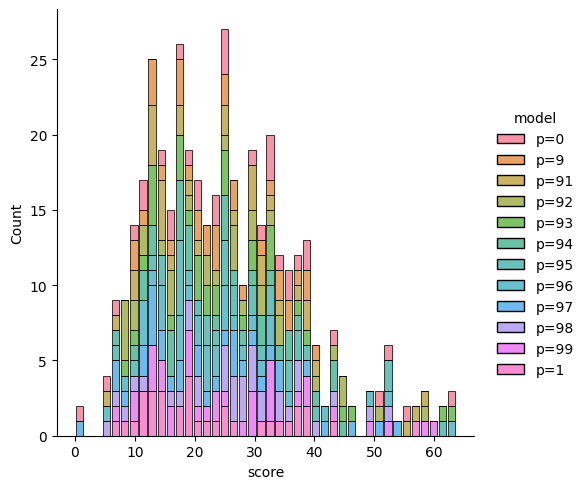

In [ ]:
sns.displot(df, x="score", hue="model", kind="hist", multiple="stack", shrink=0.8, binwidth=1.5)

/tmp/ipykernel_760118/2157746874.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p9_metric.mean(),
/tmp/ipykernel_760118/2157746874.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p91_metric.mean(),
/tmp/ipykernel_760118/2157746874.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p92_metric.mean(),
/tmp/ipykernel_760118/2157746874.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will 

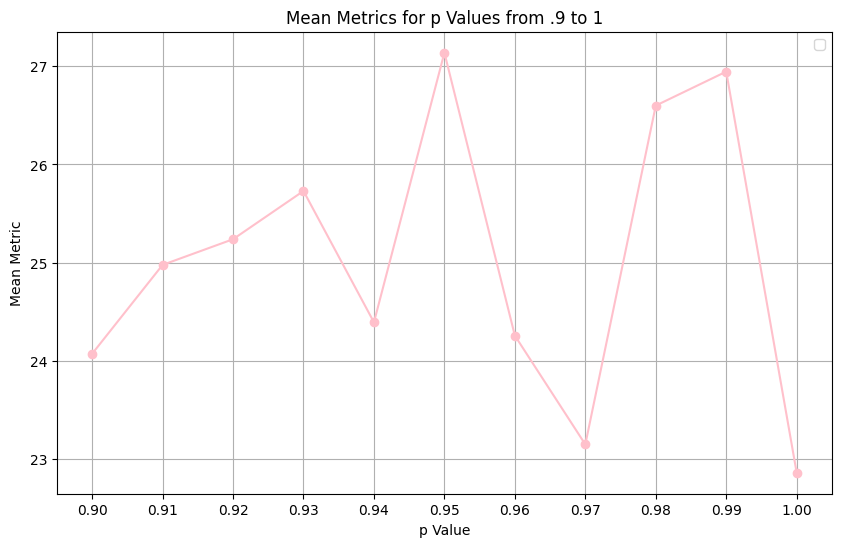

In [ ]:
import matplotlib.pyplot as plt

means_p = [
    p9_metric.mean(),
    p91_metric.mean(),
    p92_metric.mean(),
    p93_metric.mean(),
    p94_metric.mean(),
    p95_metric.mean(),
    p96_metric.mean(),
    p97_metric.mean(),
    p98_metric.mean(),
    p99_metric.mean(),
    p1_metric.mean()
]

p_values = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]

# Plotting the means
plt.figure(figsize=(10, 6))
plt.plot(p_values, means_p, marker='o', linestyle='-', color='pink')

plt.title('Mean Metrics for p Values from .9 to 1')
plt.xlabel('p Value')
plt.ylabel('Mean Metric')
plt.xticks(p_values)
plt.legend()
plt.grid(True)
plt.show()
